In [1]:
import scipy 
import cvxpy as cp
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

### In this script, we cannot compare costs because the decentralized optimization problem only correctly find the optimum decentralized K controller, not the final cost

In [38]:
def psd(n):
    """generate PSD matrix with dimension n-by-n"""
    mat = np.random.normal(0, 1, (n, n))
    return mat.T@mat

def normed_psd(n):
    """random PSD matrix with all eigvals within the unit circle"""
    psd_m = psd(n)
    return psd_m/(LA.norm(psd_m)*2)

def heuristic_X(n):
    """generate potentially more stable X_matrix by applying some heuristics"""
    X_list = []
    X_min_eigval = []
    min_eigval = 0
    while min_eigval < 0.1 and len(X_list) < 10000:
        X = normed_psd(n)
        X_list.append(X)
        try:
            assert np.all(LA.eigvals(X) > 0)
        except AssertionError:
            continue
        curr_X_eigval = LA.eigvals(X)
        X_min_eigval.append(min(curr_X_eigval))
        if min(curr_X_eigval) > min_eigval:
            min_eigval = min(curr_X_eigval)
    X_index = np.argmax(X_min_eigval)
    X = X_list[X_index]
    return X
n = 2
A = np.eye(n)
X = heuristic_X(n)
X_inv = LA.inv(X)
q_diag = np.array([10, 1])#np.random.randint(1, 10, size=n)
Q = np.diag(q_diag)

Q_dict = {}
for i in range(1, n+1):
    curr_q = np.zeros(n)
    curr_q[i-1] = q_diag[i-1]
    Q_dict[i] = np.diagflat(curr_q)

## Testing specific problem setup

In [3]:
K = cp.Variable((n, n), diag=True)
W = cp.Variable((n, n))
#decentralized
objective = cp.Maximize(cp.log_det(W))
sys_mat = A - X@K
constraints = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [4]:
K.value.toarray()

array([[3.40715239, 0.        , 0.        ],
       [0.        , 3.13497207, 0.        ],
       [0.        , 0.        , 3.36404656]])

In [5]:
np.trace(W.value)

11.170171913478484

In [6]:
Q_dict

{1: array([[7., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 2: array([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]]),
 3: array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 3.]])}

In [7]:
#centralized
K = cp.Variable((n, n), diag=True)
W = cp.Variable((n, n))
objective = cp.Minimize(cp.trace(cp.matrix_frac(np.eye(n), W)*Q))
sys_mat = A - X@K
constraints = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [8]:
print(K.value)

  (0, 0)	3.3329031716469597
  (1, 1)	2.9035586386089207
  (2, 2)	2.991236507719837


In [13]:
K = cp.Variable((n, n), diag=True)
W = cp.Variable((n, n))
objective = cp.Minimize(cp.trace(cp.matrix_frac(np.eye(n), W)*Q_dict[1]))
sys_mat = A - X@K
constraints = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [11]:
print(K.value)

  (0, 0)	3.3329031716469597
  (1, 1)	2.9035586386089207
  (2, 2)	2.991236507719837


In [12]:
K = cp.Variable((n, n), diag=True)
W = cp.Variable((n, n))
objective = cp.Minimize(cp.trace(cp.matrix_frac(np.eye(n), W)*Q_dict[2]))
sys_mat = A - X@K
constraints = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print(K.value)

  (0, 0)	3.3329031578348545
  (1, 1)	2.903558698898954
  (2, 2)	2.991236596831117


In [14]:
K = cp.Variable((n, n), diag=True)
W = cp.Variable((n, n))
objective = cp.Minimize(cp.trace(cp.matrix_frac(np.eye(n), W)*Q_dict[3]))
sys_mat = A - X@K
constraints = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print(K.value)

  (0, 0)	3.3329031716469597
  (1, 1)	2.9035586386089207
  (2, 2)	2.991236507719837


## check the distance between NE of decentralized and centralized controller 

In [40]:
NE_dist = []
for i in range(500):
    if i%10 == 0:
        print('=', end='')
    X = heuristic_X(n)
    X_inv = LA.inv(X)
    
    K = cp.Variable((n, n), diag=True)
    W = cp.Variable((n, n))
    #decentralized
    objective = cp.Maximize(cp.log_det(W))
    sys_mat = A - X@K
    constraints = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    
    curr_decentralized_NE = K.value.toarray()
    #centralized
    objective1 = cp.Minimize(cp.trace(cp.matrix_frac(np.eye(n), W)*Q))
    sys_mat = A - X@K
    constraints1 = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
    prob1 = cp.Problem(objective1, constraints1)
    result1 = prob1.solve()
    
    curr_centralized_NE = K.value.toarray()
    
    NE_dist.append((curr_decentralized_NE, curr_centralized_NE))


In [20]:

def plotting(NE_dist, xlabel = "random X", comp = False):
    K_dist = [LA.norm(p[0]-p[1]) for p in NE_dist]
    K_dist_perc = [LA.norm(p[0]-p[1])/LA.norm(p[1]) for p in NE_dist]
    
    print("average K distance between decentralized_NE and centralized_NE is ", str(np.mean(K_dist)))
    print("average K distance percentage between decentralized_NE and centralized_NE is ", str(100*np.mean(K_dist_perc)) + "%")

    if comp:
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))  

        fig.tight_layout()


        ax[0,0].plot(K_dist) 
        ax[0,0].set_xlabel("random X")
        ax[0,0].set_ylabel("NE diff")
        ax[0,0].set_title("distance between decentralized_NE and centralized_NE")

        ax[0,1].plot(K_dist_perc) 
        ax[0,1].set_xlabel("random X")
        ax[0,1].set_ylabel("NE diff in percentage")
        ax[0,1].set_title("percentage distance between decentralized_NE and centralized_NE")

        ax[1,0].plot(cost_dist) 
        ax[1,0].set_xlabel("random X")
        ax[1,0].set_ylabel("optimum diff")
        ax[1,0].set_title("distance between optimum of decentralized control and centralized control")

        ax[1,1].plot(K_dist_perc) 
        ax[1,1].set_xlabel("random X")
        ax[1,1].set_ylabel("optimum diff in percentage")
        ax[1,1].set_title("percentage distance between optimum of decentralized control and centralized control")

        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        plt.show()
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))  
    fig.tight_layout()

    
    ax[0].plot(K_dist, marker='.') 
    ax[0].set_ylabel("NE distance")
    ax[0].set_xlabel(xlabel)
    ax[0].set_title("correlation between NE distance and optimum distance")

    ax[1].plot(K_dist_perc, marker='.') 
    ax[1].set_ylabel("NE distance (perc)")
    ax[1].set_xlabel(xlabel)
    ax[1].set_title("correlation between NE distance (perc) and optimum distance (perc)")

#     ax[0].scatter(K_dist, cost_dist, marker='.') 
#     ax[0].set_xlabel("NE distance")
#     ax[0].set_ylabel("cost distance")
#     ax[0].set_title("correlation between NE distance and optimum distance")

#     ax[1].scatter(K_dist_perc, cost_dist_perc, marker='.') 
#     ax[1].set_xlabel("NE distance (perc)")
#     ax[1].set_ylabel("cost distance (perc)")
#     ax[1].set_title("correlation between NE distance (perc) and optimum distance (perc)")

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [24]:
Q

array([[7, 0, 0],
       [0, 1, 0],
       [0, 0, 3]])

### For 3-player and Q = np.diag([7, 1, 3]) scenario:

average K distance between decentralized_NE and centralized_NE is  0.6274733339138898
average K distance percentage between decentralized_NE and centralized_NE is  9.928427980853252%


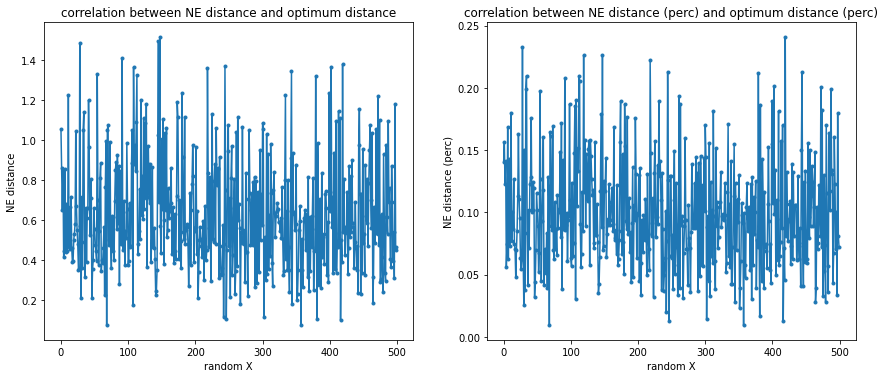

In [21]:
plotting(NE_dist)

### For 3-player and Q = np.diag([1, 1, 1]) scenario:

average K distance between decentralized_NE and centralized_NE is  0.6028655995155987
average K distance percentage between decentralized_NE and centralized_NE is  9.323756195013186%


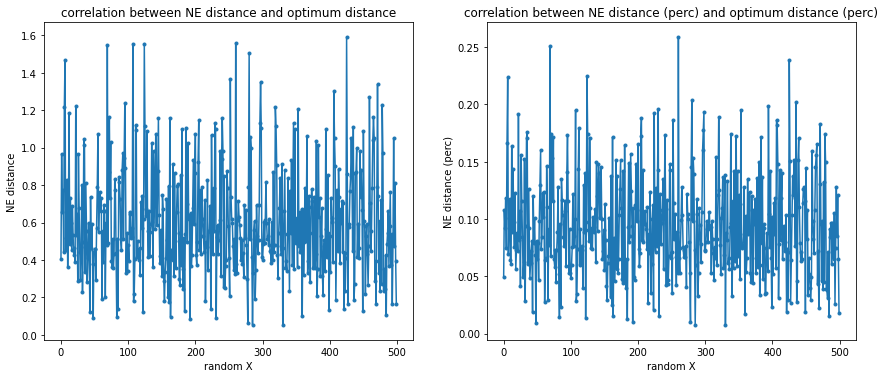

In [30]:
plotting(NE_dist)

### For 3-player and Q = np.diag([1, 1, 10]) scenario:

average K distance between decentralized_NE and centralized_NE is  0.6183783594452791
average K distance percentage between decentralized_NE and centralized_NE is  9.927548950046901%


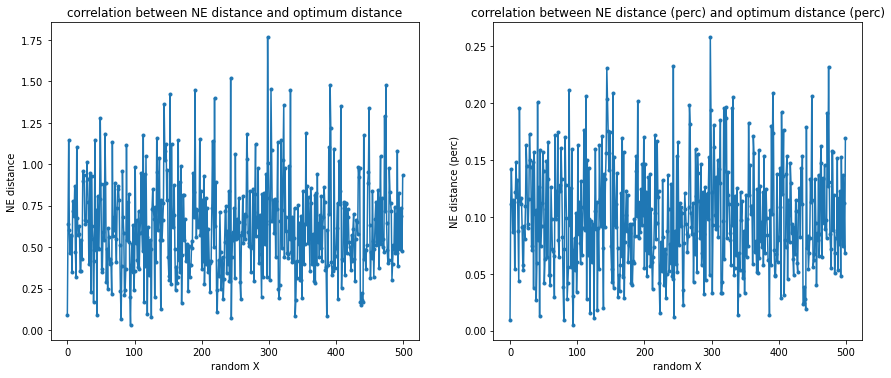

In [34]:
plotting(NE_dist)

### For 2-player and Q = np.diag([1, 10]) scenario:

average K distance between decentralized_NE and centralized_NE is  0.4219704810967935
average K distance percentage between decentralized_NE and centralized_NE is  9.468639338881031%


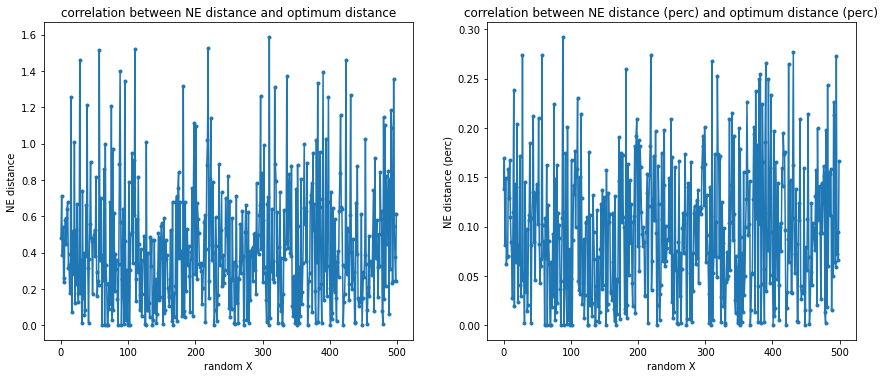

In [39]:
plotting(NE_dist)

### For 2-player and Q = np.diag([10, 1]) scenario:

average K distance between decentralized_NE and centralized_NE is  0.4514130231700197
average K distance percentage between decentralized_NE and centralized_NE is  9.95619220258295%


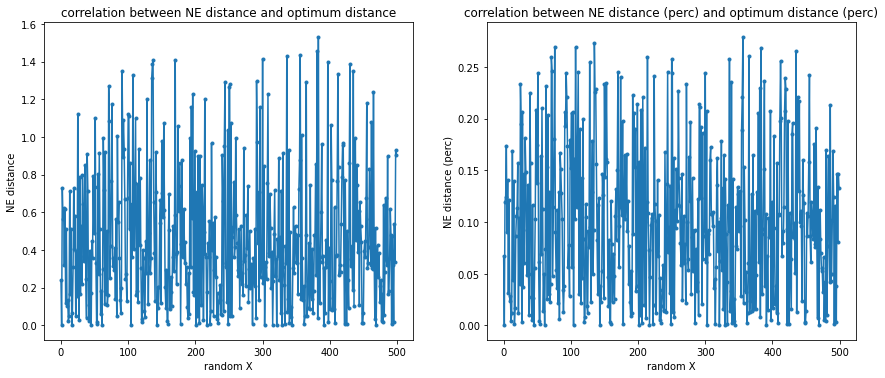

In [41]:
plotting(NE_dist)

## check the trend between NE difference and diagonal dominance level of X

In [53]:
q_diag = np.array([1, 1])#np.random.randint(1, 10, size=n)
Q = np.diag(q_diag)

Q_dict = {}
for i in range(1, n+1):
    curr_q = np.zeros(n)
    curr_q[i-1] = q_diag[i-1]
    Q_dict[i] = np.diagflat(curr_q)

In [54]:
NE_dist = []
for alpha in np.arange(0, 1, 0.01):
    X = np.array([[1, alpha], [alpha, 1]])
    print('=', end='')
    
    K = cp.Variable((n, n), diag=True)
    W = cp.Variable((n, n))
    #decentralized
    objective = cp.Maximize(cp.log_det(W))
    sys_mat = A - X@K
    constraints = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    curr_decentralized_NE = K.value.toarray()
    
    #centralized
    objective1 = cp.Minimize(cp.trace(cp.matrix_frac(np.eye(2), W)*Q))
    sys_mat = A - X@K
    constraints1 = [cp.bmat([[X_inv, K], [K, 2*K-W]]) >> 0, sys_mat - np.eye(n) << 0, sys_mat + np.eye(n) >> 0, K >> 0]
    prob1 = cp.Problem(objective1, constraints1)
    result1 = prob1.solve()
    
    curr_centralized_NE = K.value.toarray()
    
    NE_dist.append((curr_decentralized_NE, curr_centralized_NE))


In [55]:
K_dist = [LA.norm(p[0]-p[1]) for p in NE_dist]
K_dist_perc = [LA.norm(p[0]-p[1])/LA.norm(p[1]) for p in NE_dist]


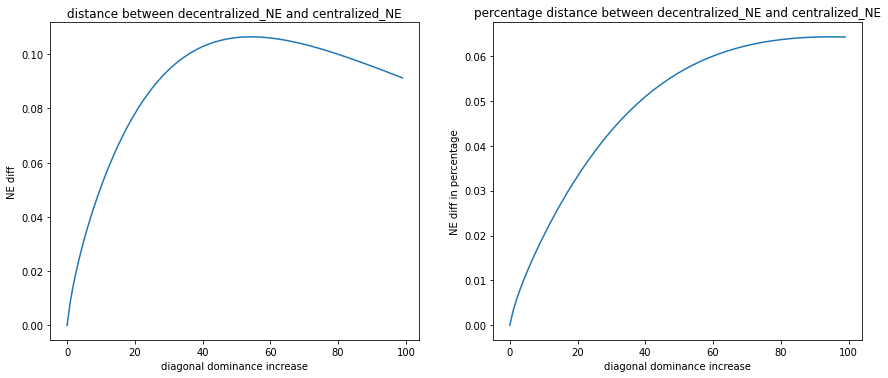

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))  

fig.tight_layout()


ax[0].plot(K_dist) 
ax[0].set_xlabel("diagonal dominance increase")
ax[0].set_ylabel("NE diff")
ax[0].set_title("distance between decentralized_NE and centralized_NE")

ax[1].plot(K_dist_perc) 
ax[1].set_xlabel("diagonal dominance increase")
ax[1].set_ylabel("NE diff in percentage")
ax[1].set_title("percentage distance between decentralized_NE and centralized_NE")

fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

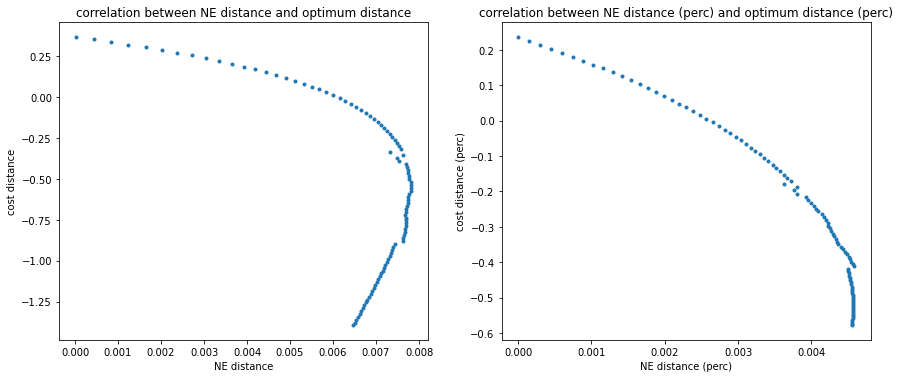

In [95]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))  

# fig.tight_layout()


# ax[0].scatter(K_dist, cost_dist, marker='.') 
# ax[0].set_xlabel("NE distance")
# ax[0].set_ylabel("cost distance")
# ax[0].set_title("correlation between NE distance and optimum distance")

# ax[1].scatter(K_dist_perc, cost_dist_perc, marker='.') 
# ax[1].set_xlabel("NE distance (perc)")
# ax[1].set_ylabel("cost distance (perc)")
# ax[1].set_title("correlation between NE distance (perc) and optimum distance (perc)")

# fig.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.show()